In [1]:
import compAut as ca
import sys
from random import choices
from pygments import highlight
from pygments.lexers import CLexer
from pygments.formatters import HtmlFormatter
from IPython.core.display import HTML

# Regexp syntax

The regexp syntax follows (loosely) PCRE syntax without grouping and backreference.
We construct the automaton the obvious way and minimize it.


In [2]:
regexp = ".*[^a-zA-Z][Cc]omp[aA]ut[^a-zA-Z].*"
L = ca.logics.cre.compile(regexp)

It is possible to display thanks to graphviz the automaton:

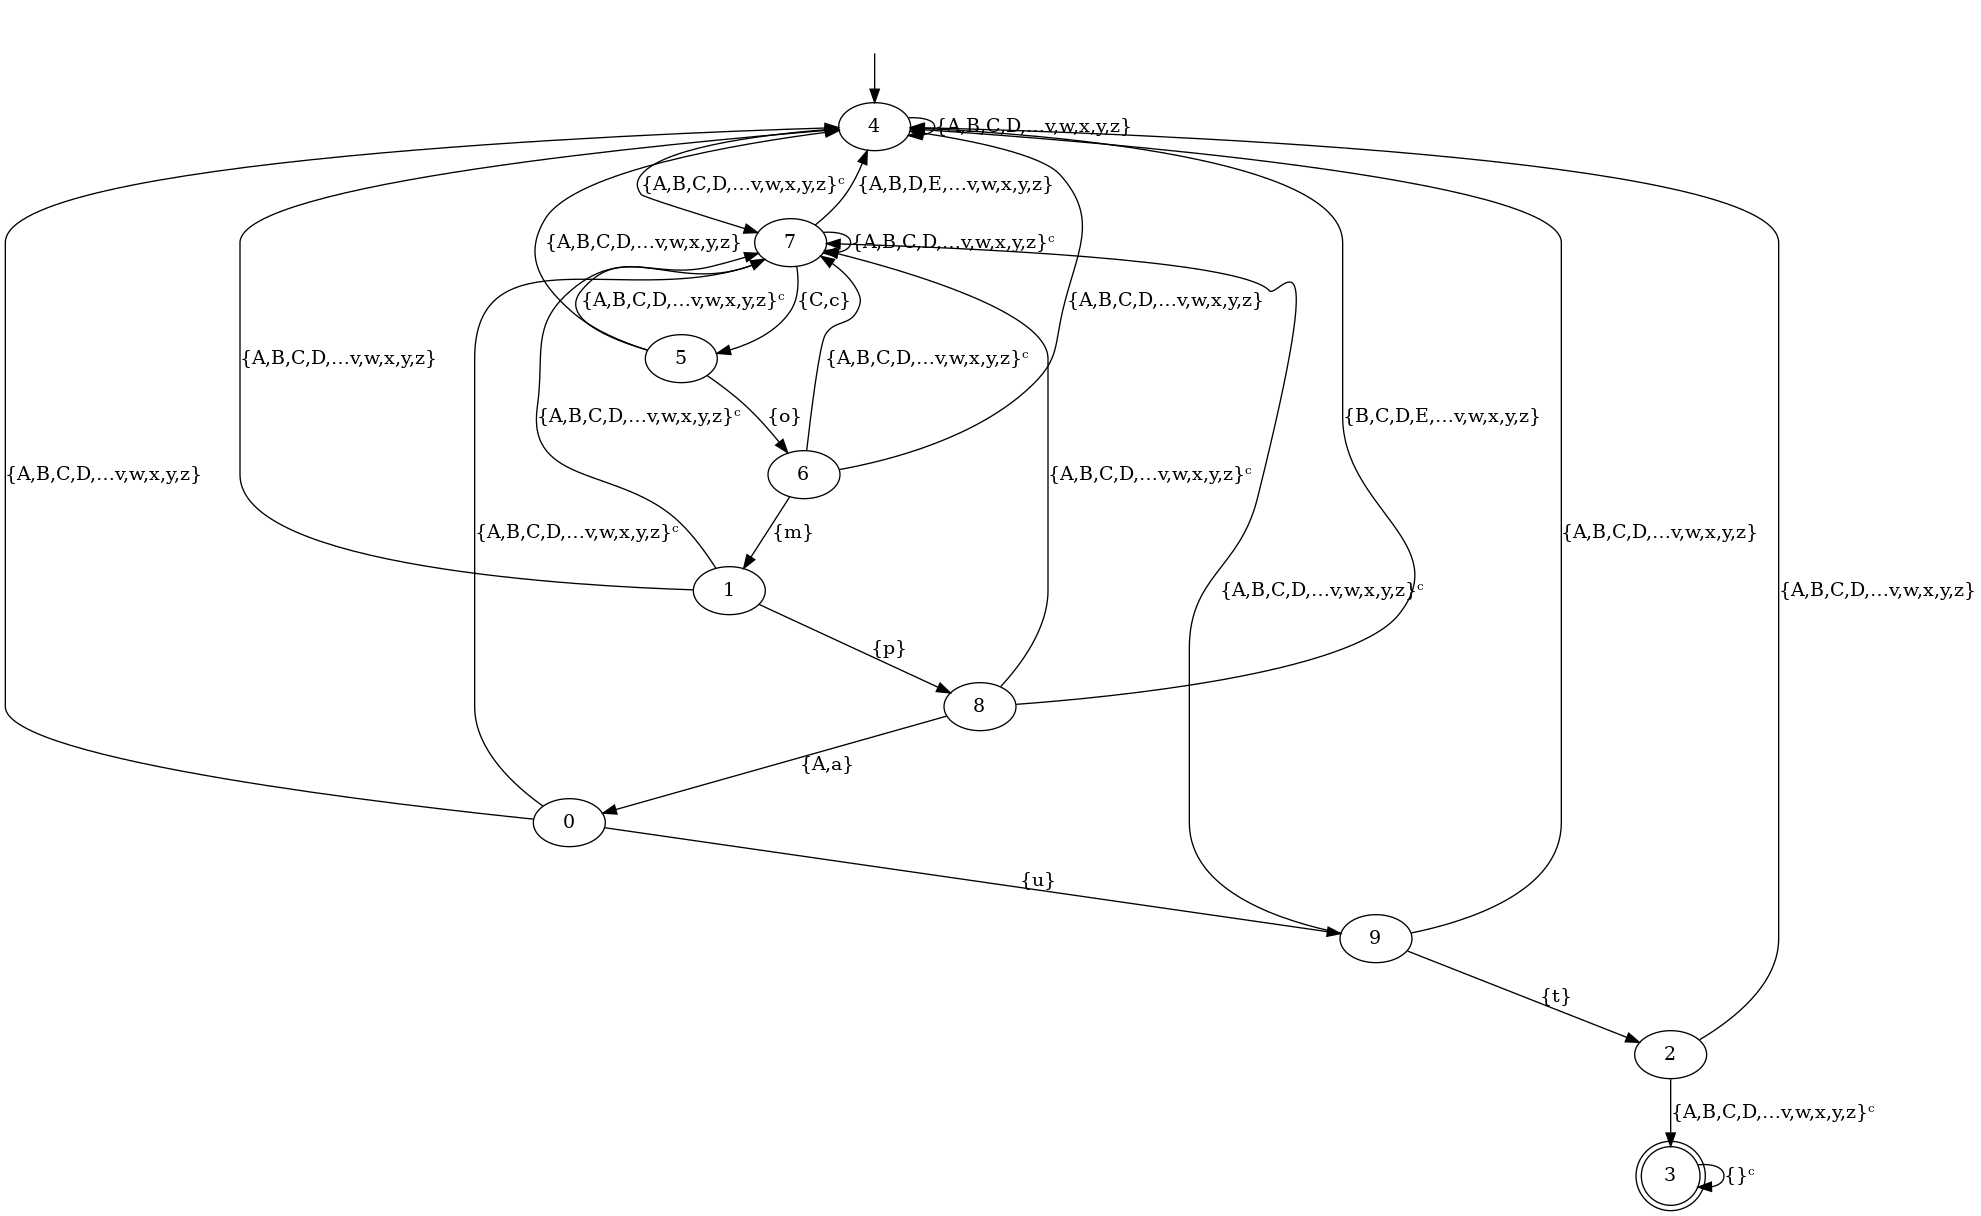

In [3]:
L.show()

# Internal representation
The automaton is simply seen as a (non mutable) tuple of transitions. Transitions are triple (source, set-of-letters, target) except that the letters can represent cofinite set of letters. It form a symbolic representations of the transitions of an automaton over a possibly infinite alphabet.

In [4]:
it = L.iter_transitions()
print(next(it))
print(next(it))

(4, {A,B,C,D,…v,w,x,y,z}, 4)
(4, {A,B,C,D,…v,w,x,y,z}ᶜ, 7)


Here, the set of letters denotes everything which is not `C` or `c`. 
The internal structure is a dict of dict of dict of dict (with the last "of dict" being useless for automaton model but useful for other models of computation)

In [5]:
L._transitions

{4: {{A,B,C,D,…v,w,x,y,z}: {4: None}, {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 7: {{C,c}: {5: None},
  {A,B,D,E,…v,w,x,y,z}: {4: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 5: {{o}: {6: None},
  {A,B,C,D,…v,w,x,y,z}: {4: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 6: {{m}: {1: None},
  {A,B,C,D,…v,w,x,y,z}: {4: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 1: {{A,B,C,D,…v,w,x,y,z}: {4: None},
  {p}: {8: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 8: {{B,C,D,E,…v,w,x,y,z}: {4: None},
  {A,a}: {0: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 0: {{A,B,C,D,…v,w,x,y,z}: {4: None},
  {u}: {9: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 9: {{A,B,C,D,…v,w,x,y,z}: {4: None},
  {t}: {2: None},
  {A,B,C,D,…v,w,x,y,z}ᶜ: {7: None}},
 2: {{A,B,C,D,…v,w,x,y,z}: {4: None}, {A,B,C,D,…v,w,x,y,z}ᶜ: {3: None}},
 3: {{}ᶜ: {3: None}}}

# Automaton as a model of computation
One can execute the automaton over some iterables with the method `is_accepted`

In [6]:
L.is_accepted("foo CompAut bar")

True

Nothing is assumed over the alphabet, hence we can feed arbitrary sequences of arbitrary Python object:

In [7]:
L.is_accepted((1, 2)+tuple("compaut")+(object(),))

True

The automaton represents the regular language it computes. Hence, it inherits the set ability:


In [8]:
"foo CompAut bar" in L

True

In [9]:
"foo compAut bar" in L

True

In [10]:
"foo ComppAut bar" in L

False

In [11]:
("c", "o", "m", "p", "a", "u", "t") in L

False

# Automaton operations

The automaton model support all classical regular operations. Each operation produce a new automaton (nothing is in place).

In [12]:
K = L.concatenate(L)

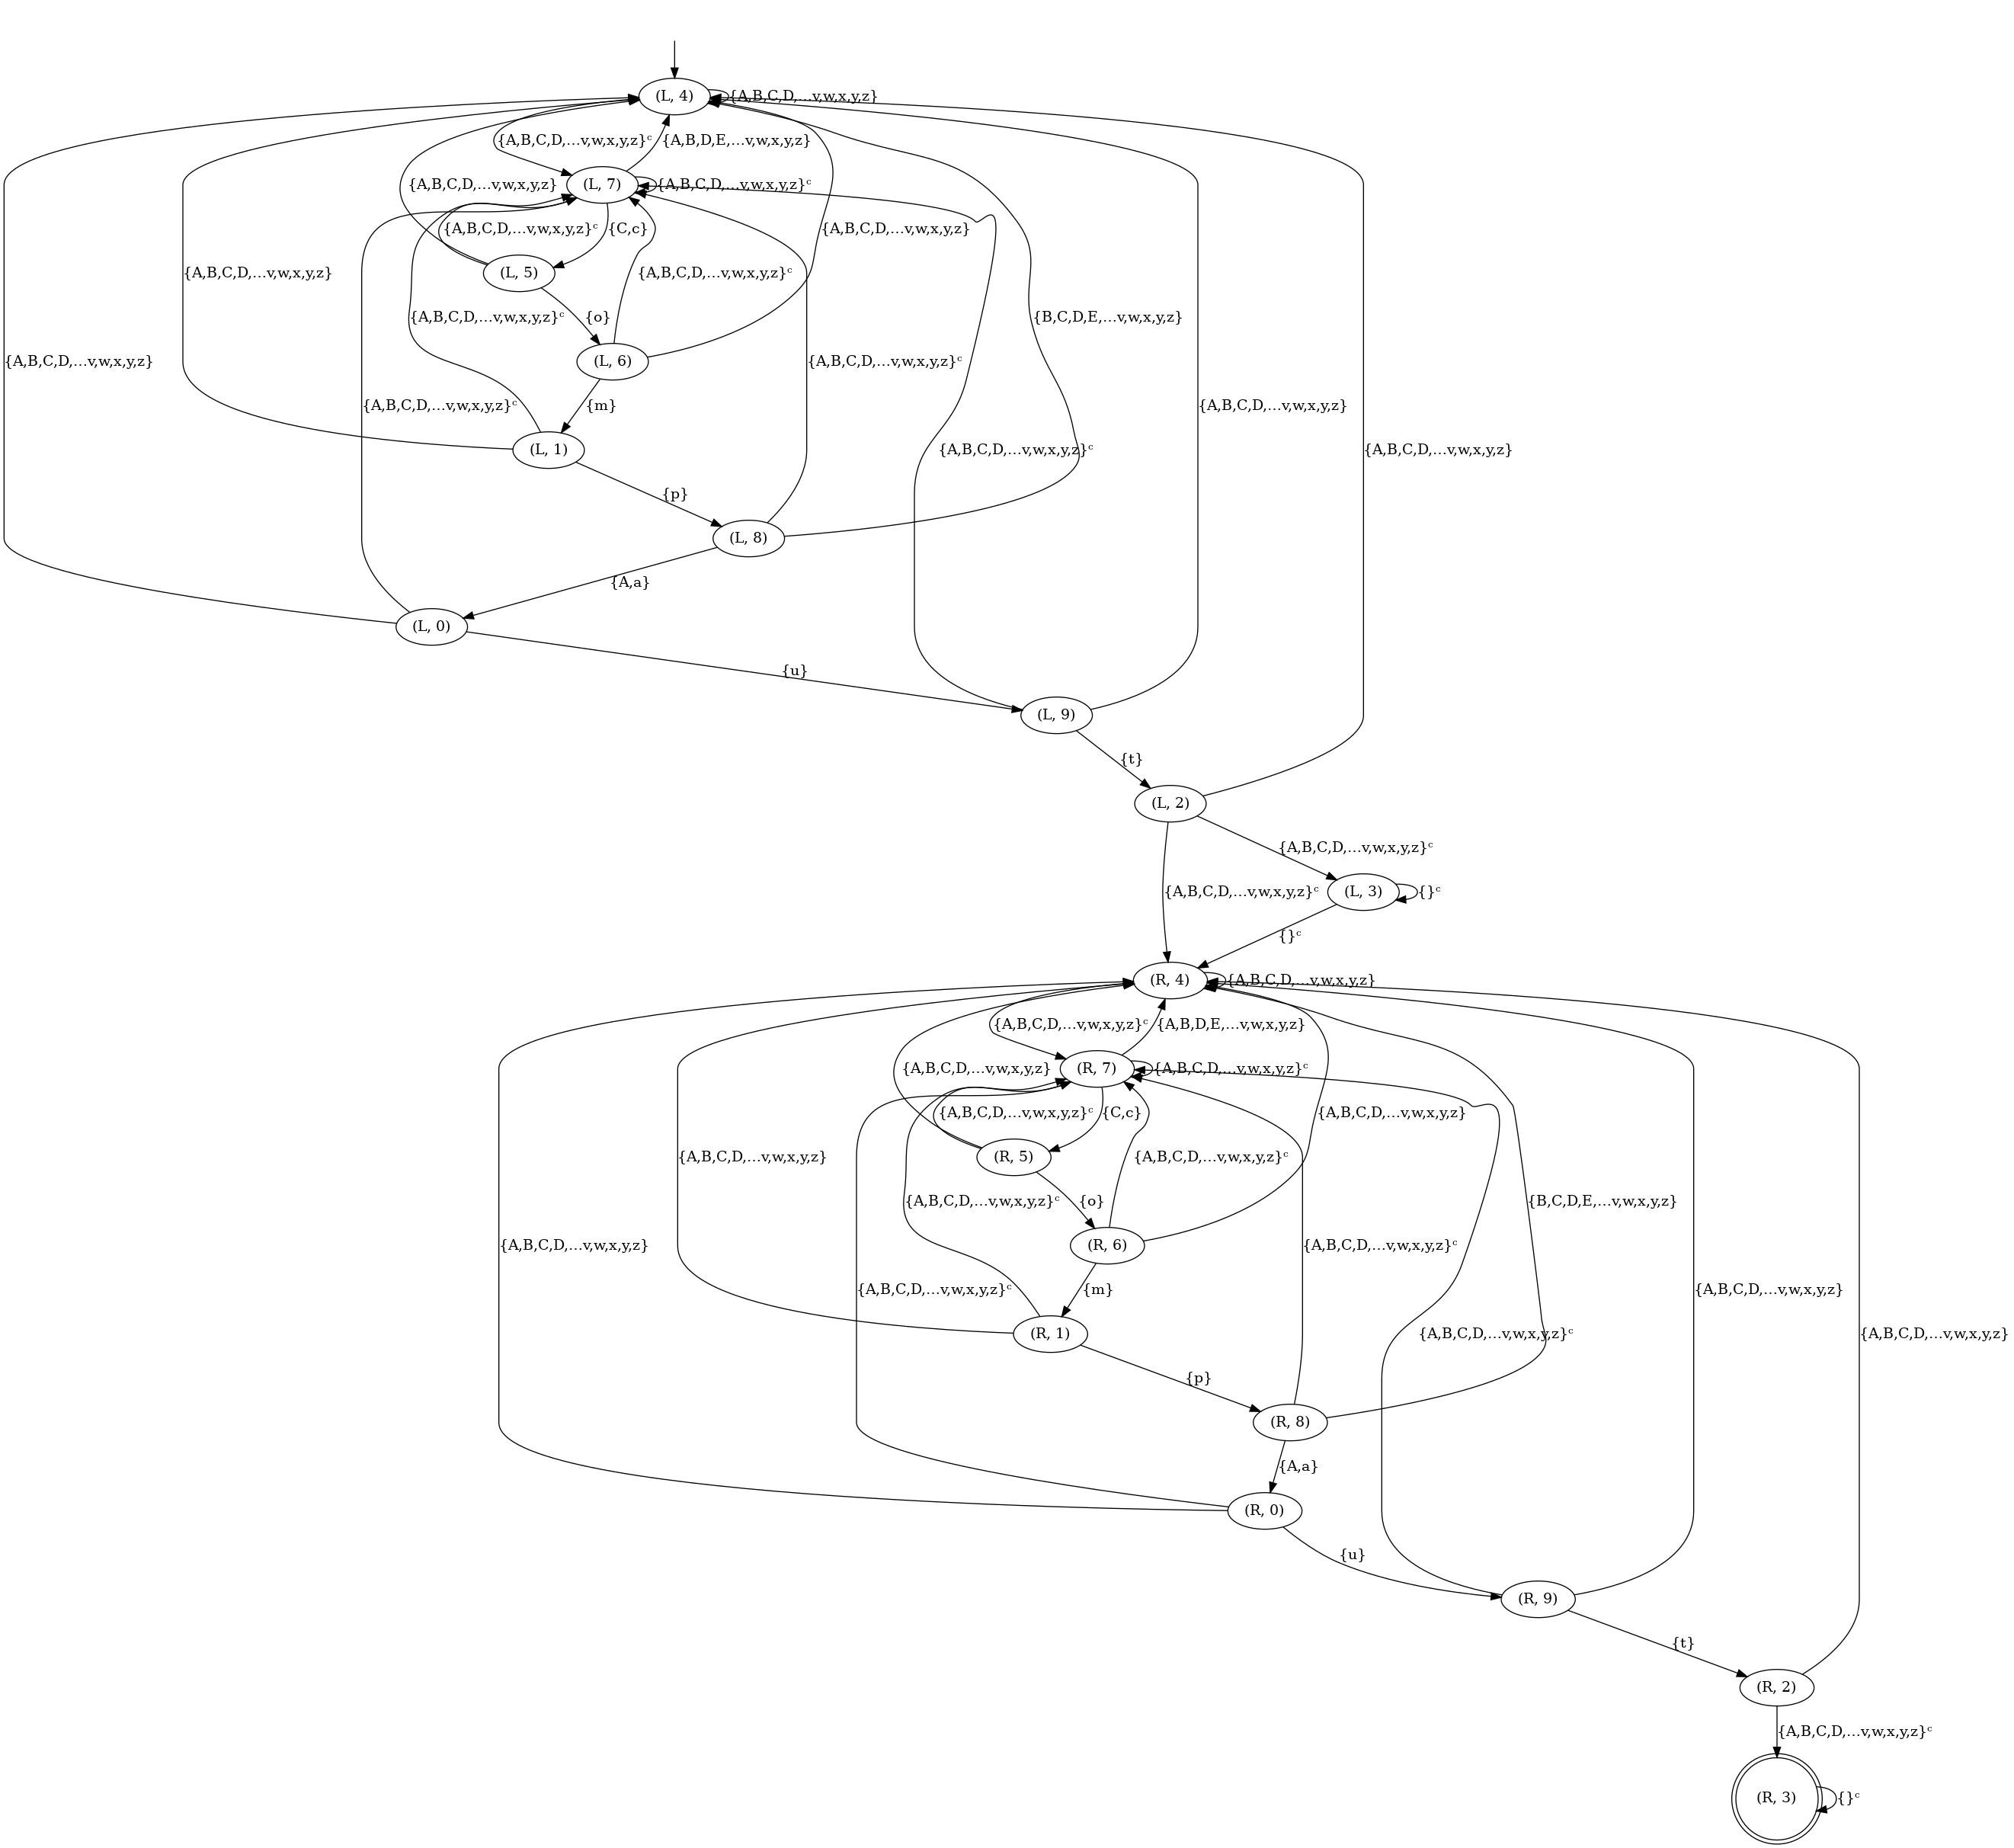

In [13]:
K.show()

In [14]:
"foo CompAut  CompAut bar" in K, "foo CompAut bar" in K

(True, False)

All sets operation (complement, intersection, union, difference) are supported over automaton without any assumption over the alphabet. Minimisation is done silently and could be inneficient in some cases. 

# Performance
Such an automate is nice to manipulate but not efficient to execute. 

In [15]:
import re
Lre = re.compile(regexp, re.DOTALL)

In [16]:
s = "".join(choices("abcdefghijklmnopqrstuvxyz", k=5*10**7)) + " compaut " + "".join(choices("abcdefghijklmnopqrstuvxyz", k=10**7))  
# ~20 Mo string

In [17]:
%time m = Lre.match(s)

CPU times: user 99.8 ms, sys: 0 ns, total: 99.8 ms
Wall time: 99.6 ms


Performance is around ~ 5Gbyte/s
To compare:

In [18]:
%time s.index(" ")

CPU times: user 3.08 ms, sys: 0 ns, total: 3.08 ms
Wall time: 3.09 ms


50000000

index is mapped to memchr which is highly performant. Here it reach: ~18Gbyte/s which is the upper limit
of the hardware bandwidth.

In [19]:
%time L.is_accepted(s)

CPU times: user 42.4 s, sys: 2.93 ms, total: 42.4 s
Wall time: 42.5 s


True

The code here is pure python, (a simple for loops updating the inner state). The performance reached is without
a surprise really bad. At each step, it pays the cost of solving symbolic computation on the fly and the cost of Python itself.

# Compilation

A mecanism of static compilation allows to build a standalone binaries based on the abstract automaton.
We compile to a grep like standalone program.

In [20]:
%time M = ca.machines.SwitchGrepLikeAutomaton(regexp) # this is slow!

CPU times: user 507 ms, sys: 7.7 ms, total: 514 ms
Wall time: 514 ms


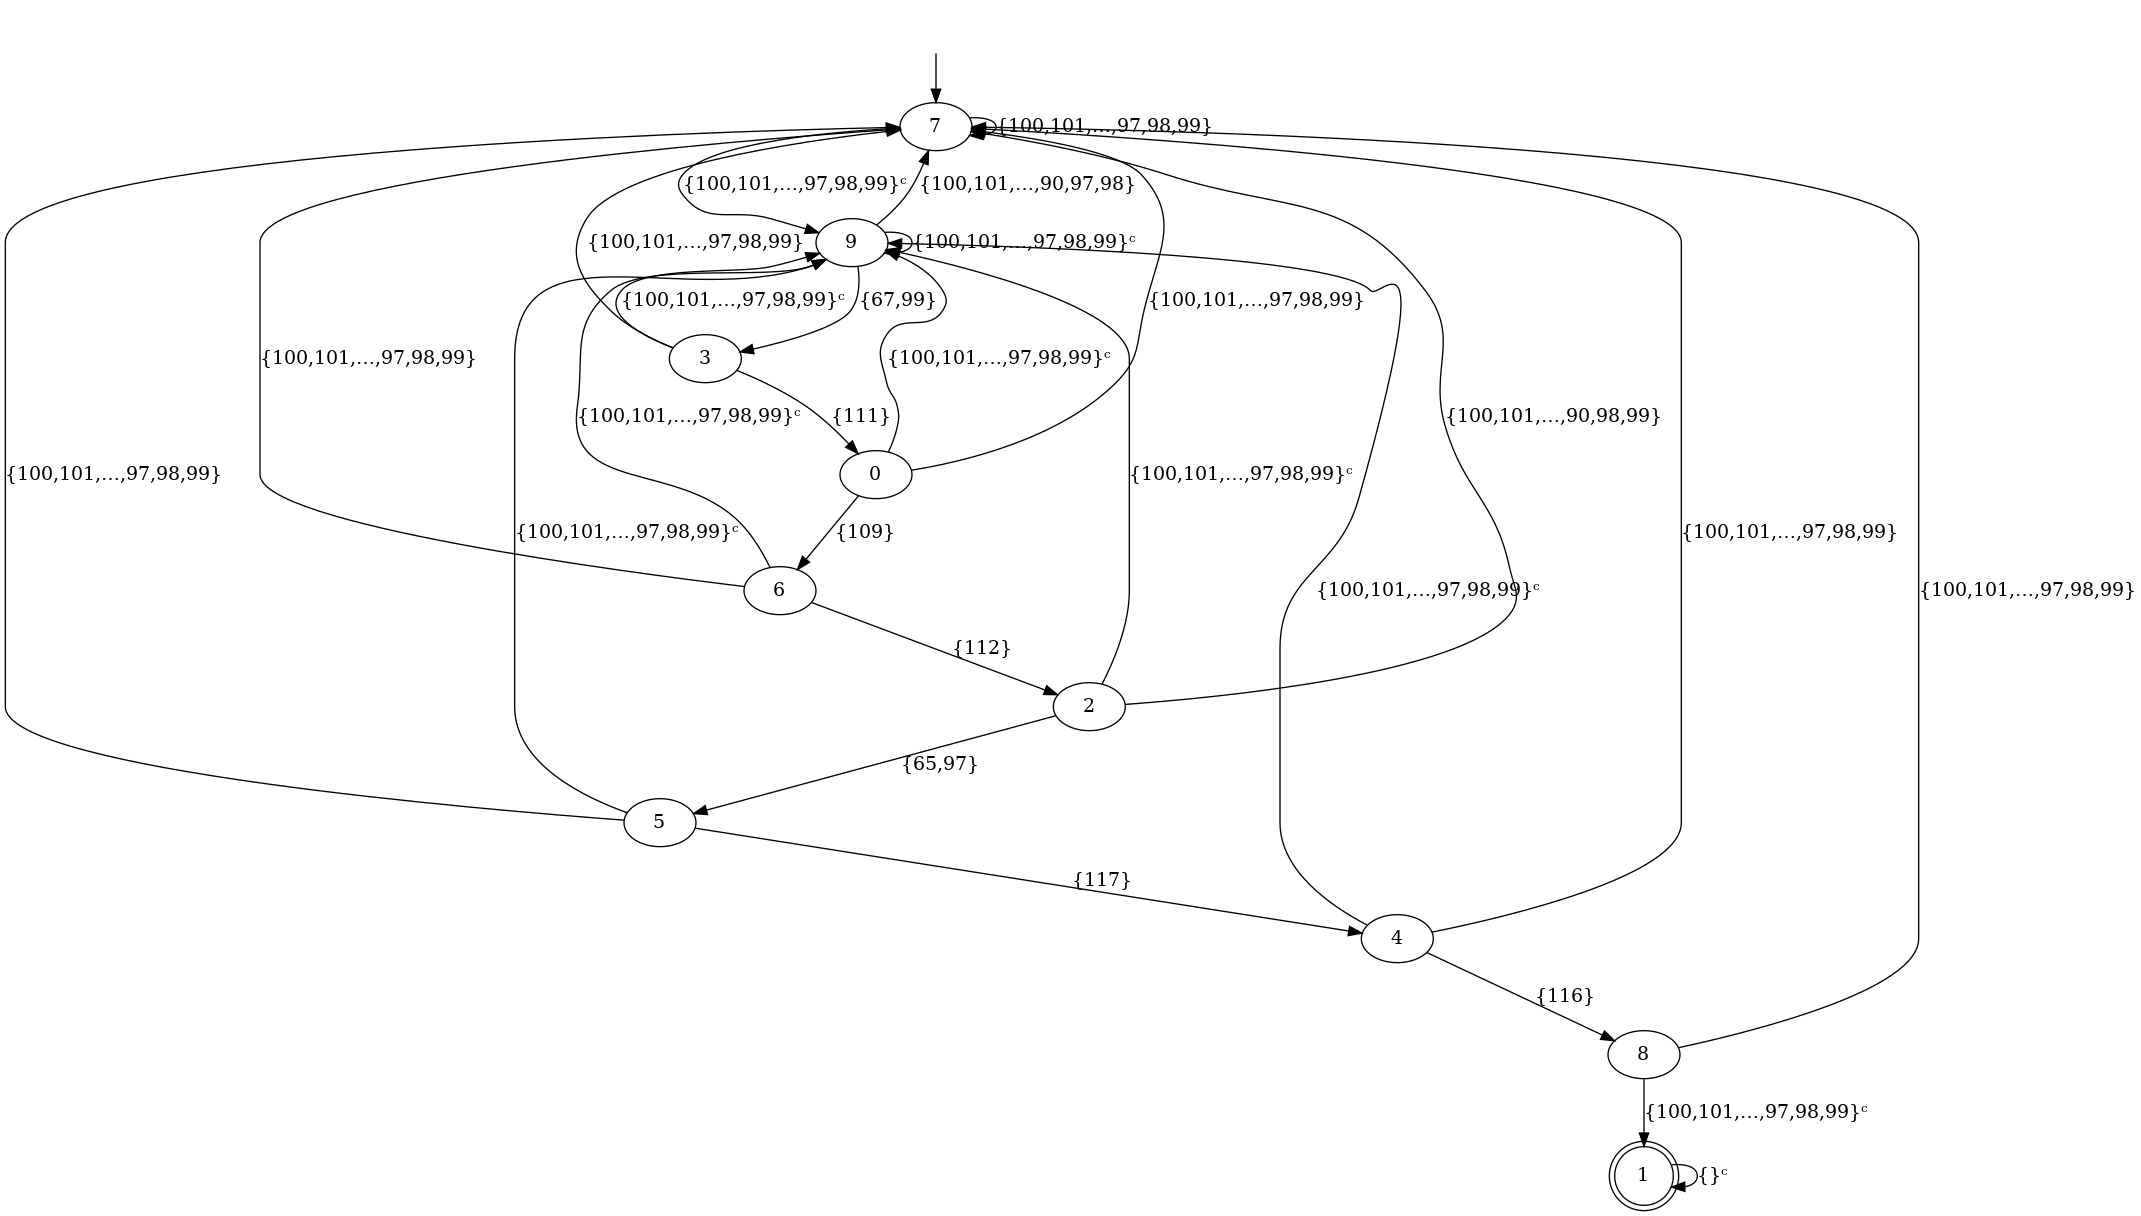

In [21]:
M.automaton.show() #the Automaton is now working on Bytes, ready to read bytes and not meta-abstraction

In [22]:
%time M.compile() # Generate the binaries, it is slow, call gcc with all optimization triggered

CPU times: user 2.41 ms, sys: 4.02 ms, total: 6.44 ms
Wall time: 115 ms


In [23]:
%time r = M.execute_on_str(s)

CPU times: user 37.2 ms, sys: 48.2 ms, total: 85.4 ms
Wall time: 163 ms


The perfomance are not as good as re but it is executed on another process with inter process communication.

We can investigate the code. The main interesting functions of the standalone programs looks like:

In [24]:
machine_code = M.sources()["machine"]

In [25]:
HTML(highlight(machine_code, CLexer(), HtmlFormatter(full=True)))